In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.preprocessing import MinMaxScaler
import talib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV

In [2]:
def features_creation(df, forecast):
    df["H-L"] = df["High"]- df["Low"]
    df["C-O"] = df["Close"] - df["Open"]
    df["7_rolling_mean"]= df["Close"].rolling(7).mean()
    df["14_rolling_mean"]= df["Close"].rolling(14).mean()
    df["21_rolling_mean"]= df["Close"].rolling(21).mean()
    df["30_rolling_mean"]= df["Close"].rolling(30).mean()
    df["60_rolling_mean"]= df["Close"].rolling(60).mean()
    df["7_rolling_STD"]= df["Close"].rolling(7).std()
    df["Close_forecast"]= df["Close"].copy().shift(-forecast)
    df["Close_difference"] = df["Close"] - df["Close_forecast"] 
    df['Date'] = pd.to_datetime(df.index)  # Convert the 'Date' index to datetime if needed
    df['timedelta']=df['Date'].diff(-forecast).dt.days
    df['day_of_week'] = df['Date'].dt.dayofweek
    df["month"]= df["Date"].dt.month
    df["end_of_month"]= df["Date"].dt.is_month_end.astype(int)
    df["RSI"] = talib.RSI(df["Close"], timeperiod=14)
    df["RSI45"] = talib.RSI(df["Close"], timeperiod=14)
    df["upper_band"], df["middle_band"], df["lower_band"] = talib.BBANDS(df["Close"], timeperiod=20)
    df["macd"], df["macd_signal"], df["macd_hist"] = talib.MACD(df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
    # Calculate the stochastic oscillator
    df["stochastic_k"], df["stochastic_d"] = talib.STOCH(df["High"], df["Low"], df["Close"], fastk_period=14, slowk_period=3, slowd_period=3)
    df = df.dropna()
    return(df)
def create_train_test_set(df_Stock):
    features = df_Stock[['Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'day_of_week',
 'month',
 "end_of_month",
 'H-L',
 'C-O',
 '7_rolling_mean',
 '14_rolling_mean',
 '21_rolling_mean',
 '30_rolling_mean',
 '60_rolling_mean',
 '7_rolling_STD', 
 'timedelta','RSI', 'RSI45',
  'upper_band',
 'middle_band',
 'lower_band',
 'macd',
 'macd_signal',
 'macd_hist',
 'stochastic_k',
 'stochastic_d',
 'day_of_week',
#  'month',
 "end_of_month",
                         ]]

    target = df_Stock[["Close_difference"]]
    data_len = df_Stock.shape[0]
    test_split = int(data_len * 0.7)
    #val_split = train_split + int(data_len * 0.1)
    # Splitting features and target into train, validation and test samples 
    X_train, X_test = features[:test_split], features[test_split:]
    Y_train, Y_test = target[:test_split], target[test_split:], 
    X_val = features[-n:]
    Y_val = target[-n:]

    #print shape of samples
    print(X_train.shape,  X_test.shape)
    print(Y_train.shape,  Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test, X_val, Y_val
def forest_gr():
    forest_grid_1 = {

    'n_estimators': [100],  
    'max_depth': np.arange(1, 10, 1),  
    'min_samples_split': [2], 
    'min_samples_leaf': np.arange(9, 13, 1, dtype=int),  
    'bootstrap': [True, False]} 
    
    return forest_grid_1
lasso_parameters = {
 "alpha": np.arange(0.01, 1.0, 0.1),
    "max_iter": [1000]
 }
ridge_parameters = {
 "alpha": np.arange(0.01, 1.0, 0.1),
    "max_iter": [1000]
 }
# def SVR_poly():
#     # List of C values
#     C_range = np.logspace(-1, 1, 3)
#     degree_range = [1, 2, 3, 4, 5, 6]
#     # List of gamma values
#     gamma_range = np.logspace(-1, 1, 3)
#     param_grid = { 
#     # Regularization parameter.
#     "C": C_range,
#     # Kernel type
#     "kernel": ['poly'],
#     "degree": degree_range,
#     # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
#     "gamma": gamma_range.tolist()+['scale', 'auto']
#     }
#     return param_grid
def SVR_poly():
    # List of C values
    C_range = np.arange(1, 10, 0.1)
    degree_range = [1, 2]
    # List of gamma values
    gamma_range = np.arange(0.1, 5, 0.5)
#    coef0_range = np.arange(0.00, 1.0, 0.1)
    param_grid = { 
    # Regularization parameter.
    "C": C_range,
#     "coef0": coef0_range,
    # Kernel type
    "kernel": ['poly'],
    "degree": degree_range,
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
    }
    return param_grid
def SVR_rbf():
    # List of C values
    C_range = np.arange(0.1, 2, 0.1)
    # List of gamma values
    gamma_range = np.arange(5, 7, 0.2)
    param_grid = { 
    # Regularization parameter.
    "C": C_range,
    # Kernel type
    "kernel": ['rbf'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
    }
    return param_grid
def SVR_linear():
    # List of C values
    C_range = np.arange(0.1, 5, 0.1)
    gamma_range = np.arange(5, 9, 0.1)
    param_grid = { 
    # Regularization parameter.
    "C": C_range,
    # Kernel type
    "kernel": ['linear'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
    }
    return param_grid
tscv = TimeSeriesSplit(n_splits=10)
n = 99

In [3]:
import xgboost as xgb

In [4]:
import xgboost as xgb
def pipeline_feature_selection(df, historical_data_y, forecast_d):
    df = features_creation(df, forecast_d)
    X_train, X_test, Y_train,  Y_test, X_val, Y_val = create_train_test_set(df)
    
    Y_train_naive_pred = df.iloc[:int(len(df)*0.7), :]["Close"]
    Y_test_naive_pred = df.iloc[int(len(df)*0.7):, :]["Close"]
    Y_val_naive_pred = df.iloc[-n:, :]["Close"]
    
    close_train = df.iloc[:int(len(df)*0.7), :]["Close"] 
    close_test = df.iloc[int(len(df)*0.7):, :]["Close"]
    close_val = df.iloc[-n:, :]["Close"]
    
    close_forecast_train = df.iloc[:int(len(df)*0.7), :]["Close_forecast"] 
    close_forecast_test = df.iloc[int(len(df)*0.7):, :]["Close_forecast"]
    close_forecast_val = df.iloc[-n:, :]["Close_forecast"]
    
    std_test = np.std(Y_test.values)
    std_train = np.std(Y_train.values)
    std_val = np.std(Y_val.values)
    
    rfecv = RFECV(estimator=xgb.XGBRegressor(), step=1, min_features_to_select=5, cv=10, scoring="neg_mean_absolute_percentage_error", n_jobs= -1)
    selected_features_train = rfecv.fit_transform(X_train, np.array(Y_train.values).reshape(-1))
    selected_features_test = rfecv.transform(X_test)
    selected_features_val = rfecv.transform(X_val)
    
    selected_feature_indices = rfecv.support_
    selected_features_names = X_train.columns[selected_feature_indices]

    
    pipelines = [Pipeline(steps = [('regressor',GridSearchCV(estimator = LinearRegression(), param_grid = {} ))]),
             Pipeline(steps = [("scaler", MinMaxScaler()),('regressor',GridSearchCV(estimator = Lasso(),param_grid = lasso_parameters, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1))]),
             Pipeline(steps = [("scaler", MinMaxScaler()),('regressor',GridSearchCV(estimator = Ridge(),param_grid = ridge_parameters, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2,n_jobs=-1))]),
             Pipeline(steps = [("scaler", StandardScaler()),('regressor',RandomizedSearchCV(estimator = RandomForestRegressor(),param_distributions = forest_gr(),n_iter=20, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))]),
             Pipeline(steps = [("scaler", StandardScaler()),('regressor',RandomizedSearchCV(estimator = SVR(),param_distributions = SVR_rbf(), n_iter=20, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))]),
             Pipeline(steps = [("scaler", StandardScaler()),('regressor',RandomizedSearchCV(estimator = SVR(),param_distributions = SVR_linear(), n_iter=20, cv = tscv, scoring = "neg_mean_absolute_percentage_error", verbose=2, n_jobs=-1, random_state=42))])
                              ]
    results = {
    "company": "SP",
    "historical data": historical_data_y,
    "features": "feature selection",
    "std_ratio_test": std_test/std_train,
    "std_ratio_val": std_val/std_train,
    "forecast (days)": forecast_d,
    "model": ["Naive", "Linear regression", "Lasso REgularization", "Ridge Regularization", "Random Forest Regresssor",  "SVR, kernel = rbf", "SVR, kernel = linear"],
    "best parameters": ["Naive"],
    "train RMSE": [mean_squared_error(close_forecast_train, Y_train_naive_pred, squared=False)],
    "test RMSE": [mean_squared_error(close_forecast_test, Y_test_naive_pred, squared=False)],
    "train residuals": [[m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)]],
    "test residuals": [[m - n for m,n in zip(close_forecast_test, Y_test_naive_pred.values)]],
    "Y train": [Y_train.values],
    "Y test": [Y_test.values],
    "ranking": [selected_features_names],
    "forecast_train predicted": [Y_train_naive_pred],
    "forecast_test predicted": [Y_test_naive_pred],
    "train MAPE": [mean_absolute_percentage_error(close_forecast_train, Y_train_naive_pred)],
    "test MAPE": [mean_absolute_percentage_error(close_forecast_test, Y_test_naive_pred)],
    "mean residual": [np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)]))],
    "Y_train predicted + mean residual":[[i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_train_naive_pred]],
    "Y_test predicted + mean residual":[[i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_test_naive_pred]],
    "MAPE zero residuals train": [mean_absolute_percentage_error(close_forecast_train, [i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_train_naive_pred])],
    "MAPE zero residuals test": [mean_absolute_percentage_error(close_forecast_test, [i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_test_naive_pred])],   
    
    "MAPE zero residuals val": [mean_absolute_percentage_error(close_forecast_val, [i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_val_naive_pred])],   
   
        
    "RMSE zero residuals train": [mean_squared_error(close_forecast_train, [i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_train_naive_pred], squared=False)],
    "RMSE zero residuals test": [mean_squared_error(close_forecast_test, [i+ np.mean(list([m - n for m,n in zip(close_forecast_train, Y_train_naive_pred.values)])) for i in Y_test_naive_pred], squared=False)]   

    }
    print("H = ", historical_data_y)
    print()
    print("Forecast = ",  forecast_d)
    print()

    for pipeline in pipelines:
        model = pipeline.fit(selected_features_train, np.array(Y_train.values.reshape(-1)))
        model_predict_train = model.predict(selected_features_train)
        model_predict_test = model.predict(selected_features_test)
        model_predict_val = model.predict(selected_features_val)
        predictions_train = close_train - model_predict_train
        predictions = close_test - model_predict_test
        
        predictions_val = close_val - model_predict_val
        
        results["best parameters"].append(model.named_steps['regressor'].best_params_)
        
    
       
        results["train RMSE"].append(mean_squared_error(close_forecast_train, predictions_train, squared=False))
        results["test RMSE"].append(mean_squared_error(close_forecast_test, predictions, squared=False))
    
    
    
        results["train residuals"].append([m - n for m,n in zip(Y_train.values, model_predict_train)])
        results["test residuals"].append([m - n for m,n in zip(Y_test.values, model_predict_test)])
    
        results["forecast_train predicted"].append(predictions_train)
        results["forecast_test predicted"].append(predictions)
        
        
        results["train MAPE"].append(mean_absolute_percentage_error(close_forecast_train, predictions_train))
        results["test MAPE"].append(mean_absolute_percentage_error(close_forecast_test, predictions))
        
        mean_residual = np.mean(list([m - n for m,n in zip(Y_train.values, model_predict_train)]))
        results["mean residual"].append(mean_residual)
        
        results["Y_train predicted + mean residual"].append([i- mean_residual for i in predictions_train])
        results["Y_test predicted + mean residual"].append([i- mean_residual for i in predictions])
        
        results["MAPE zero residuals train"].append(mean_absolute_percentage_error(close_forecast_train, [i- mean_residual for i in predictions_train]))
        results["MAPE zero residuals test"].append(mean_absolute_percentage_error(close_forecast_test, [i- mean_residual for i in predictions]))
        
        results["MAPE zero residuals val"].append(mean_absolute_percentage_error(close_forecast_val, [i- mean_residual for i in predictions_val]))
        
        results["RMSE zero residuals train"].append(mean_squared_error(close_forecast_train, [i- mean_residual for i in predictions_train], squared=False))
        results["RMSE zero residuals test"].append(mean_squared_error(close_forecast_test, [i- mean_residual for i in predictions], squared=False))
        
        

    return results


    


In [5]:
sp_df_2 = yf.download('^GSPC', 
                      start='2021-05-01', 
                      end='2023-04-30',
                      progress=False)
sp_df_5 = yf.download('^GSPC', 
                      start='2018-05-01', 
                      end='2023-04-30', 
                      progress=False)
sp_df_10 =  yf.download('^GSPC', 
                      start='2013-05-01', 
                      end='2023-04-30', 
                      progress=False)
sp_df_15 =  yf.download('^GSPC', 
                      start='2008-05-01', 
                      end='2023-04-30',  
                      progress=False)

<Axes: xlabel='Date'>

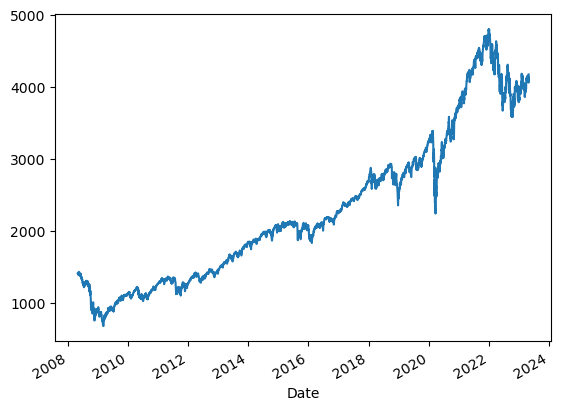

In [6]:
sp_df_15["Close"].plot()

In [7]:
len(sp_df_15)

3775

In [8]:
np.random.seed(123)
results_2h_5f = pipeline_feature_selection(sp_df_2, 2, 5)
results_2h_15f = pipeline_feature_selection(sp_df_2, 2, 15)
results_2h_30f = pipeline_feature_selection(sp_df_2, 2, 30)
results_2h_60f = pipeline_feature_selection(sp_df_2, 2, 60)

# results_5h_5f = pipeline_feature_selection(sp_df_5, 5, 5)
# results_5h_15f = pipeline_feature_selection(sp_df_5, 5, 15)
# results_5h_30f = pipeline_feature_selection(sp_df_5, 5, 30)
# results_5h_60f = pipeline_feature_selection(sp_df_5, 5, 60)

# results_10h_5f = pipeline_feature_selection(sp_df_10, 10, 5)
# results_10h_15f = pipeline_feature_selection(sp_df_10, 10, 15)
# results_10h_30f = pipeline_feature_selection(sp_df_10, 10, 30)
# results_10h_60f = pipeline_feature_selection(sp_df_10, 10, 60)

# results_15h_5f = pipeline_feature_selection(sp_df_15, 15, 5)
# results_15h_15f = pipeline_feature_selection(sp_df_15, 15, 15)
# results_15h_30f = pipeline_feature_selection(sp_df_15, 15, 30)
# results_15h_60f = pipeline_feature_selection(sp_df_15, 15, 60)

(306, 30) (132, 30)
(306, 1) (132, 1)
H =  2

Forecast =  5

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.961e+01, tolerance: 2.681e+01
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.971e+03, tolerance: 4.494e+01
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
(299, 30) (129, 30)
(299, 1) (129, 1)
H =  2

Forecast =  15

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.672e+01, tolerance: 1.746e+01
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e+03, tolerance: 8.968e+01
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
(289, 30) (124, 30)
(289, 1) (124, 1)
H =  2

Forecast =  30

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.4100000000

[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0

[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11,

H =  2

Forecast =  60

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=1

/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e+01, tolerance: 5.843e+00
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.632e+02, tolerance: 6.101e+01
  model = cd_fast.enet_coordinate_descent(


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=2.3000000000000003, gamma=8.099999999999989, kernel=linear; total time=   0.0s
[CV] END C=2.3000000000000003, gamma=8.099999999999989, kernel=linear; total time=   0.0s
[CV] END C=2.3000000000000003, gamma=8.099999999999989, kernel=linear; total time=   0.0s
[CV] END C=2.3000000000000003, gamma=8.099999999999989, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END .

In [9]:
results_5h_5f = pipeline_feature_selection(sp_df_5, 5, 5)
results_5h_15f = pipeline_feature_selection(sp_df_5, 5, 15)
results_5h_30f = pipeline_feature_selection(sp_df_5, 5, 30)
results_5h_60f = pipeline_feature_selection(sp_df_5, 5, 60)

# results_10h_5f = pipeline_feature_selection(sp_df_10, 10, 5)
# results_10h_15f = pipeline_feature_selection(sp_df_10, 10, 15)
# results_10h_30f = pipeline_feature_selection(sp_df_10, 10, 30)
# results_10h_60f = pipeline_feature_selection(sp_df_10, 10, 60)

# results_15h_5f = pipeline_feature_selection(sp_df_15, 15, 5)
# results_15h_15f = pipeline_feature_selection(sp_df_15, 15, 15)
# results_15h_30f = pipeline_feature_selection(sp_df_15, 15, 30)
# results_15h_60f = pipeline_feature_selection(sp_df_15, 15, 60)

(835, 30) (359, 30)
(835, 1) (359, 1)
H =  5

Forecast =  5

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=8.799999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=8.799999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=8.799999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=8.799999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=8.799999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=8.799999999999986, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=5.399999999999999, kernel=linear; tota

/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e+04, tolerance: 2.870e+01
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.851e+03, tolerance: 6.876e+01
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fitting 10 folds for each of 20 candidates, totalling 200 fits
   0.0s
[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; total time=   0.0s
[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; total time=   0.0s
[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; total time=   0.0s
[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004

/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.596e+03, tolerance: 1.061e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e+04, tolerance: 1.168e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

ax_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   

[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=6, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=6, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=10, min_

[CV] END ......................C=1.8, gamma=auto, kernel=rbf; total time=   0.0sFitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=8.799999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=8.799999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=2.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ....................C=4.0, gamma=5.0, kernel=linear; total time=   0.0s
[CV] END ....................C=4.0, gamma=5.0, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.0, gamma=6.999999999999993, 

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0

(828, 30) (356, 30)
(828, 1) (356, 1)
H =  5

Forecast =  15

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; tot

/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.446e+03, tolerance: 5.605e+01
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.975e+04, tolerance: 1.908e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fitting 10 folds for each of 20 candidates, totalling 200 fits


/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.027e+04, tolerance: 2.915e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.333e+05, tolerance: 3.223e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

.......alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=

[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=10,

(818, 30) (351, 30)
(818, 1) (351, 1)
H =  5

Forecast =  30

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END C=4.1000000000000005, gamma=5.499999999999998, kernel=linear; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time= 

/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.453e+02, tolerance: 1.235e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.620e+03, tolerance: 3.754e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

......alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samp

[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ...................

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996,

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split

(797, 30) (342, 30)
(797, 1) (342, 1)
H =  5

Forecast =  60

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.323e+04, tolerance: 1.421e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.329e+03, tolerance: 7.696e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fitting 10 folds for each of 20 candidates, totalling 200 fits


ty gap: 1.874e+06, tolerance: 3.854e+03
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.638e+06, tolerance: 4.465e+03
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.947e+06, tolerance: 4.890e+03
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0

[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ...................

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ......................C=1.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=1.8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.6000000000000001, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.7000000000000002, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.7000000000000002, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.0s
[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.0s
[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.0s
[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.0s
[CV] END .......

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END .........C=1.8, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.8, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.8, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.8, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.8, gamma=6.600000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=0.2, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5

In [10]:

results_10h_5f = pipeline_feature_selection(sp_df_10, 10, 5)
results_10h_15f = pipeline_feature_selection(sp_df_10, 10, 15)
results_10h_30f = pipeline_feature_selection(sp_df_10, 10, 30)
results_10h_60f = pipeline_feature_selection(sp_df_10, 10, 60)

# results_15h_5f = pipeline_feature_selection(sp_df_15, 15, 5)
# results_15h_15f = pipeline_feature_selection(sp_df_15, 15, 15)
# results_15h_30f = pipeline_feature_selection(sp_df_15, 15, 30)
# results_15h_60f = pipeline_feature_selection(sp_df_15, 15, 60)

(1717, 30) (736, 30)
(1717, 1) (736, 1)
H =  10

Forecast =  5

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END .........C=1.1, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.1, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.

[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=10

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END C=2.3000000000000003, gamma=8.099999999999989, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=5.799999999999997, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=5.799999999999997, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[

[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ...................

Fitting 10 folds for each of 20 candidates, totalling 200 fits
(1710, 30) (733, 30)
(1710, 1) (733, 1)
H =  10

Forecast =  15

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.658e+01, tolerance: 2.984e+01
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.061e+03, tolerance: 1.997e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ..........

[CV] END .........C=1.1, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END .........C=1.5, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=0.30000000000000004, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002,

(1699, 30) (729, 30)
(1699, 1) (729, 1)
H =  10

Forecast =  30

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_le

/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.329e+03, tolerance: 1.186e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.516e+02, tolerance: 3.539e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

1000000000000005, gamma=5.499999999999998, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, ker

[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7

[CV] END ......C=3.0, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END C=4.1000000000000005, gamma=5.499999999999998, kernel=linear; total time=   0.0s
[CV] END C=4.1000000000000005, gamma=5.499999999999998, kernel=linear; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.0s
[

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=False, max_depth=7, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.2s


Fitting 10 folds for each of 20 candidates, totalling 200 fits
(1678, 30) (720, 30)
(1678, 1) (720, 1)
H =  10

Forecast =  60

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=4, min_samp

/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.846e+04, tolerance: 9.198e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.997e+04, tolerance: 1.669e+03
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.1s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.1s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.0s
[CV] END .....C=0.1, gamma=7

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C

[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=4, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_s

In [11]:
results_15h_5f = pipeline_feature_selection(sp_df_15, 15, 5)
results_15h_15f = pipeline_feature_selection(sp_df_15, 15, 15)
results_15h_30f = pipeline_feature_selection(sp_df_15, 15, 30)
results_15h_60f = pipeline_feature_selection(sp_df_15, 15, 60)

(2597, 30) (1114, 30)
(2597, 1) (1114, 1)
H =  15

Forecast =  5

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=6, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=9, min_samples_

/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.444e+04, tolerance: 5.647e+01
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.927e+02, tolerance: 2.472e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ...................

[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=1.8, gamma=8.299999999999988, kernel=linear; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] EN

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.400000000000001, kernel=rbf; total time=   0.1s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.1s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.1s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.1s
[CV] END C=1.2000000000000002, gamma=5.399999999999999, kernel=linear; total time=   

(2590, 30) (1111, 30)
(2590, 1) (1111, 1)
H =  15

Forecast =  15

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.991e+02, tolerance: 3.393e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.196e+02, tolerance: 3.723e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END C=4.1000000000000005, gamma=5.499999999999998, kernel=linear; total time=   0.0s
[CV] END C=4.1000000000000005, gamma=5.499999999999998, kernel=linear; total time=   0.0s
[CV] END C=4.1000000000000005, gamma=5.499999999999998, kernel=linear; total time=   0.0s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.1s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.1s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=

[CV] END .........C=1.5, gamma=6.800000000000002, kernel=rbf; total time=   0.1s
[CV] END .........C=1.5, gamma=6.800000000000002, kernel=rbf; total time=   0.1s
[CV] END .........C=1.5, gamma=6.800000000000002, kernel=rbf; total time=   0.1s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.000000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.400000000000001, kernel=rbf; total time=   0.0s
[CV] END C=1.9000000000000001, gamma=6.400000000000001, kernel=rbf; total time=   0.1s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ..........................alpha=0.31, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, min_samp

(2580, 30) (1106, 30)
(2580, 1) (1106, 1)
H =  15

Forecast =  30

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=9

/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.120e+03, tolerance: 4.944e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.055e+03, tolerance: 5.651e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

003, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.41000000000000003, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=3.6, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END ......C=0.4, gamma=5.399999999999999, kernel=linear; total time=   0.0s
[CV] END C=4.1000000000000005, gamma=5.499999999999998, kernel=linear;

[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=10, min

[CV] END bootstrap=True, max_depth=8, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.1sFitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ....................

(2559, 30) (1097, 30)
(2559, 1) (1097, 1)
H =  15

Forecast =  60

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.974e+04, tolerance: 8.309e+02
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.983e+05, tolerance: 1.014e+03
  model = cd_fast.enet_coordinate_descent(
/Users/maryna/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.91, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; to

[CV] END C=1.2000000000000002, gamma=5.399999999999999, kernel=linear; total time=   0.1s
[CV] END C=1.2000000000000002, gamma=5.399999999999999, kernel=linear; total time=   0.2s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.1s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.1s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.1s
[CV] END C=1.9000000000000001, gamma=6.299999999999995, kernel=linear; total time=   0.2s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.1s
[CV] END .....C=0.1, gamma=7.0999999999999925, kernel=linear; total time=   0.2s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.0s
[CV] END C=1.2000000000000002, gamma=6.199999999999996, kernel=linear; total time=   0.1s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................al

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; total time=   0.1s
[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; total time=   0.1s
[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; total time=   0.1s
[CV] END ......C=0.8, gamma=8.599999999999987, kernel=linear; total time=   0.2s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.1s
[CV] END ......C=3.7, gamma=5.299999999999999, kernel=linear; total time=   0.2s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END C=2.9000000000000004, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.0s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.1s
[CV] END ......C=1.1, gamma=8.899999999999986, kernel=linear; total time=   0.1s
[CV] END ......C=1.1, gamma=

[CV] END C=2.9000000000000004, gamma=5.799999999999997, kernel=linear; total time=   0.2s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.11, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, max_iter=1000; total time=   0.0s
[CV] END ..........

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=3, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=6, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=6, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=9, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0

In [12]:
import pandas as pd

def create_results_dataframe(results, h, f):
    data = []
    columns = [
        "Model", "Historical data", "Forecast", "Mean Residual",
        "Train MAPE (Biased)", "Test MAPE (Biased)",
        "Train MAPE (Unbiased)", "Test MAPE (Unbiased)",
        "Train RMSE (Biased)", "Test RMSE (Biased)",
        "Train RMSE (Unbiased)", "Test RMSE (Unbiased)", "MAPE zero residuals val", "std_ratio_test", "std_ratio_val", "Ranking"
    ]
    
    for i in range(len(results["model"])):
        model = results["model"][i]
        mean_residual = results["mean residual"][i]
        train_mape_biased = results["train MAPE"][i]
        test_mape_biased = results["test MAPE"][i]
        train_mape_unbiased = results['MAPE zero residuals train'][i]
        test_mape_unbiased = results['MAPE zero residuals test'][i]
        train_rmse_biased = results["train RMSE"][i]
        test_rmse_biased = results["test RMSE"][i]
        train_rmse_unbiased = results['RMSE zero residuals train'][i]
        test_rmse_unbiased = results['RMSE zero residuals test'][i]
        val_mape = results["MAPE zero residuals val"][i]
        std_r_val = results["std_ratio_val"]
        std_r_test = results["std_ratio_test"]
        features = results["ranking"]
        row = [
            model, h, f, mean_residual,
            train_mape_biased, test_mape_biased,
            train_mape_unbiased, test_mape_unbiased,
            train_rmse_biased, test_rmse_biased,
            train_rmse_unbiased, test_rmse_unbiased, val_mape, std_r_val, std_r_test, features
        ]
        data.append(row)
    
    df = pd.DataFrame(data, columns=columns)
    lower_mape_unbiased = df["Test MAPE (Unbiased)"].min()
    lower_mape_val = df["MAPE zero residuals val"].min()
    lower_rmse_unbiased = df["Test RMSE (Unbiased)"].min()

    # Find the models with the lowest MAPE and RMSE values
    best_mape_model = df[df["Test MAPE (Unbiased)"] == lower_mape_unbiased]["Model"].iloc[0]
    best_mape_model_val = df[df["MAPE zero residuals val"] == lower_mape_val]["Model"].iloc[0]
    best_rmse_model = df[df["Test RMSE (Unbiased)"] == lower_rmse_unbiased]["Model"].iloc[0]
    
    print(f"Best model based on lower MAPE test unbiased: {best_mape_model}")
    print(f"The Lowest MAPE test unbiased: {round(lower_mape_unbiased,5)}")
    print(f"STD ratio test: {round(std_r_test, 5)}")
    print()
    print()
    print(f"Best model based on lower MAPE val unbiased: {best_mape_model_val}")
    print(f"The Lowest MAPE val unbiased: {round(lower_mape_val,5)}")
    print(f"STD ratio val: {round(std_r_val,5)}")
    print()
    print()
    
    return df

# Example usage
# Replace 'results', 'h', and 'f' with your actual data
results_df_2_5 = create_results_dataframe(results_2h_5f, 2, 5)
results_df_2_5 = create_results_dataframe(results_2h_60f, 2, 60)

Best model based on lower MAPE test unbiased: SVR, kernel = rbf
The Lowest MAPE test unbiased: 0.01828
STD ratio test: 0.73343


Best model based on lower MAPE val unbiased: SVR, kernel = rbf
The Lowest MAPE val unbiased: 0.01681
STD ratio val: 0.68599


Best model based on lower MAPE test unbiased: SVR, kernel = linear
The Lowest MAPE test unbiased: 0.04483
STD ratio test: 0.47354


Best model based on lower MAPE val unbiased: Lasso REgularization
The Lowest MAPE val unbiased: 0.04811
STD ratio val: 0.40598




In [13]:
def create_results_dataframe(results, h, f):
    data = []
    columns = [
        "Model", "Historical data", "Forecast", "Mean Residual",
        "Train MAPE (Biased)", "Test MAPE (Biased)",
        "Train MAPE (Unbiased)", "Test MAPE (Unbiased)",
        "Train RMSE (Biased)", "Test RMSE (Biased)",
        "Train RMSE (Unbiased)", "Test RMSE (Unbiased)", "MAPE zero residuals val", "std_ratio_test", "std_ratio_val", "ranking"
    ]
    
    for i in range(len(results["model"])):
        model = results["model"][i]
        mean_residual = results["mean residual"][i]
        train_mape_biased = results["train MAPE"][i]
        test_mape_biased = results["test MAPE"][i]
        train_mape_unbiased = results['MAPE zero residuals train'][i]
        test_mape_unbiased = results['MAPE zero residuals test'][i]
        train_rmse_biased = results["train RMSE"][i]
        test_rmse_biased = results["test RMSE"][i]
        train_rmse_unbiased = results['RMSE zero residuals train'][i]
        test_rmse_unbiased = results['RMSE zero residuals test'][i]
        val_mape = results["MAPE zero residuals val"][i]
        std_r_val = results["std_ratio_val"]
        std_r_test = results["std_ratio_test"]
        ranking = results["ranking"]  # Get the ranking information
        row = [
            model, h, f, mean_residual,
            train_mape_biased, test_mape_biased,
            train_mape_unbiased, test_mape_unbiased,
            train_rmse_biased, test_rmse_biased,
            train_rmse_unbiased, test_rmse_unbiased, val_mape, std_r_val,std_r_test,ranking
        ]
        data.append(row)
        
    
    df = pd.DataFrame(data, columns=columns)
    lower_mape_unbiased = df["Test MAPE (Unbiased)"].min()
    lower_mape_val = df["MAPE zero residuals val"].min()
    lower_rmse_unbiased = df["Test RMSE (Unbiased)"].min()

# Find the models with the lowest MAPE and RMSE values
    best_mape_model = df[df["Test MAPE (Unbiased)"] == lower_mape_unbiased]["Model"].iloc[0]
    best_mape_model_val = df[df["MAPE zero residuals val"] == lower_mape_val]["Model"].iloc[0]
    best_rmse_model = df[df["Test RMSE (Unbiased)"] == lower_rmse_unbiased]["Model"].iloc[0]
    print(f"Best model based on lower MAPE test unbiased: {best_mape_model}")
    print(f"The Lowest MAPE test unbiased: {round(lower_mape_unbiased,5)}")
    print(f"STD ratio test: {round(std_r_test, 5)}")
    print()
    print()
    print(f"Best model based on lower MAPE val unbiased: {best_mape_model_val}")
    print(f"The Lowest MAPE val unbiased: {round(lower_mape_val,5)}")
    print(f"STD ratio val: {round(std_r_val,5)}")
    print()
    print()
#     print(df["ranking"])
    
    return df

# Example usage
# Replace 'results', 'h', and 'f' with your actual data
results_df_2_5 = create_results_dataframe(results_2h_5f, 2, 5)
#results_df_2_5 = create_results_dataframe(results_2h_60f, 2, 60)

Best model based on lower MAPE test unbiased: SVR, kernel = rbf
The Lowest MAPE test unbiased: 0.01828
STD ratio test: 0.73343


Best model based on lower MAPE val unbiased: SVR, kernel = rbf
The Lowest MAPE val unbiased: 0.01681
STD ratio val: 0.68599




In [14]:
results_2h_5f['MAPE zero residuals val']

[0.017266412910140434,
 0.025586653087855776,
 0.020360525988589652,
 0.022134535882631447,
 0.027779692567453367,
 0.016805433439500667,
 0.0175441442565665]

In [15]:
results_2h_60f['MAPE zero residuals val']

[0.06676273139683578,
 0.05219110078159848,
 0.04810797795693813,
 0.049753080181797846,
 0.061249638558068455,
 0.06915800094598264,
 0.04865375758313993]

In [16]:
results_df_2_15 = create_results_dataframe(results_2h_15f, 2, 15)

Best model based on lower MAPE test unbiased: SVR, kernel = linear
The Lowest MAPE test unbiased: 0.03222
STD ratio test: 0.72102


Best model based on lower MAPE val unbiased: SVR, kernel = linear
The Lowest MAPE val unbiased: 0.03088
STD ratio val: 0.70983




In [17]:
results_df_2_30 = create_results_dataframe(results_2h_30f, 2, 30)


Best model based on lower MAPE test unbiased: Random Forest Regresssor
The Lowest MAPE test unbiased: 0.03574
STD ratio test: 0.64838


Best model based on lower MAPE val unbiased: Random Forest Regresssor
The Lowest MAPE val unbiased: 0.03717
STD ratio val: 0.58262




In [18]:
results_df_2_60 = create_results_dataframe(results_2h_60f, 2, 60)

Best model based on lower MAPE test unbiased: SVR, kernel = linear
The Lowest MAPE test unbiased: 0.04483
STD ratio test: 0.47354


Best model based on lower MAPE val unbiased: Lasso REgularization
The Lowest MAPE val unbiased: 0.04811
STD ratio val: 0.40598




In [19]:
results_df_5_5 = create_results_dataframe(results_5h_5f, 5, 5)

Best model based on lower MAPE test unbiased: Random Forest Regresssor
The Lowest MAPE test unbiased: 0.02361
STD ratio test: 1.47869


Best model based on lower MAPE val unbiased: Linear regression
The Lowest MAPE val unbiased: 0.01466
STD ratio val: 1.01448




In [20]:
results_df_5_15 = create_results_dataframe(results_5h_15f, 5, 15)

Best model based on lower MAPE test unbiased: Random Forest Regresssor
The Lowest MAPE test unbiased: 0.04145
STD ratio test: 1.34243


Best model based on lower MAPE val unbiased: Ridge Regularization
The Lowest MAPE val unbiased: 0.0281
STD ratio val: 0.96297




In [21]:
results_df_5_30 = create_results_dataframe(results_5h_30f, 5, 30)

Best model based on lower MAPE test unbiased: Naive
The Lowest MAPE test unbiased: 0.05571
STD ratio test: 1.27517


Best model based on lower MAPE val unbiased: SVR, kernel = linear
The Lowest MAPE val unbiased: 0.02723
STD ratio val: 0.75901




In [22]:
results_df_5_60 = create_results_dataframe(results_5h_60f, 5, 60)

Best model based on lower MAPE test unbiased: Naive
The Lowest MAPE test unbiased: 0.0698
STD ratio test: 1.09571


Best model based on lower MAPE val unbiased: SVR, kernel = rbf
The Lowest MAPE val unbiased: 0.02305
STD ratio val: 0.46602




In [23]:
results_df_10_5 = create_results_dataframe(results_10h_5f, 10, 5)
results_df_10_5

Best model based on lower MAPE test unbiased: SVR, kernel = rbf
The Lowest MAPE test unbiased: 0.01929
STD ratio test: 1.80399


Best model based on lower MAPE val unbiased: SVR, kernel = linear
The Lowest MAPE val unbiased: 0.01586
STD ratio val: 1.50325




,Model,Historical data,Forecast,Mean Residual,Train MAPE (Biased),Test MAPE (Biased),Train MAPE (Unbiased),Test MAPE (Unbiased),Train RMSE (Biased),Test RMSE (Biased),Train RMSE (Unbiased),Test RMSE (Unbiased),MAPE zero residuals val,std_ratio_test,std_ratio_val,ranking
0,Naive,10,5,3.765026e+00,0.014329,0.019575,0.014073,0.019442,55.525132,100.232074,55.397336,100.013373,0.016726,1.50325,1.803986,"[[upper_band, middle_band, lower_band, macd, m..."
1,Linear regression,10,5,4.449479e-14,0.014113,0.020110,0.014113,0.020110,54.356063,101.407535,54.356063,101.407535,0.016108,1.50325,1.803986,"[[upper_band, middle_band, lower_band, macd, m..."
2,Lasso REgularization,10,5,-5.296999e-16,0.014049,0.019801,0.014049,0.019801,54.808140,100.433093,54.808140,100.433093,0.016587,1.50325,1.803986,"[[upper_band, middle_band, lower_band, macd, m..."
3,Ridge Regularization,10,5,-1.059400e-15,0.014076,0.020077,0.014076,0.020077,54.395016,101.202979,54.395016,101.202979,0.016259,1.50325,1.803986,"[[upper_band, middle_band, lower_band, macd, m..."
4,Random Forest Regresssor,10,5,-2.405203e-02,0.012018,0.048584,0.012018,0.048578,43.678064,217.806984,43.678058,217.786018,0.049766,1.50325,1.803986,"[[upper_band, middle_band, lower_band, macd, m..."
5,"SVR, kernel = rbf",10,5,7.113854e+00,0.013534,0.019237,0.013838,0.019290,55.355348,100.761724,54.896335,100.166276,0.016669,1.50325,1.803986,"[[upper_band, middle_band, lower_band, macd, m..."
6,"SVR, kernel = linear",10,5,6.628922e+00,0.013806,0.019266,0.014021,0.019342,55.766057,100.769488,55.370664,100.271434,0.015859,1.50325,1.803986,"[[upper_band, middle_band, lower_band, macd, m..."


In [24]:
results_df_10_15 = create_results_dataframe(results_10h_15f, 10, 15)

Best model based on lower MAPE test unbiased: SVR, kernel = linear
The Lowest MAPE test unbiased: 0.03215
STD ratio test: 1.65097


Best model based on lower MAPE val unbiased: Ridge Regularization
The Lowest MAPE val unbiased: 0.02858
STD ratio val: 1.43017




In [25]:
results_df_10_30 = create_results_dataframe(results_10h_30f, 10, 30)

Best model based on lower MAPE test unbiased: SVR, kernel = rbf
The Lowest MAPE test unbiased: 0.04379
STD ratio test: 1.5943


Best model based on lower MAPE val unbiased: SVR, kernel = linear
The Lowest MAPE val unbiased: 0.02846
STD ratio val: 1.12587




In [26]:
results_df_10_60 = create_results_dataframe(results_10h_60f, 10, 60)

Best model based on lower MAPE test unbiased: Naive
The Lowest MAPE test unbiased: 0.06122
STD ratio test: 1.69927


Best model based on lower MAPE val unbiased: SVR, kernel = linear
The Lowest MAPE val unbiased: 0.02385
STD ratio val: 0.7392




In [27]:
results_df_15_5 = create_results_dataframe(results_15h_5f, 15, 5)

Best model based on lower MAPE test unbiased: SVR, kernel = linear
The Lowest MAPE test unbiased: 0.01998
STD ratio test: 2.7526


Best model based on lower MAPE val unbiased: SVR, kernel = linear
The Lowest MAPE val unbiased: 0.01637
STD ratio val: 2.33473




In [28]:
results_df_15_15 = create_results_dataframe(results_15h_15f, 15, 15)

Best model based on lower MAPE test unbiased: Ridge Regularization
The Lowest MAPE test unbiased: 0.03575
STD ratio test: 2.97032


Best model based on lower MAPE val unbiased: Linear regression
The Lowest MAPE val unbiased: 0.03039
STD ratio val: 2.4824




In [29]:
results_df_15_30 = create_results_dataframe(results_15h_30f, 15, 30)

Best model based on lower MAPE test unbiased: SVR, kernel = linear
The Lowest MAPE test unbiased: 0.04946
STD ratio test: 2.95024


Best model based on lower MAPE val unbiased: SVR, kernel = linear
The Lowest MAPE val unbiased: 0.03138
STD ratio val: 1.96858




In [30]:
results_df_15_60 = create_results_dataframe(results_15h_60f, 15, 60)
results_df_15_60

Best model based on lower MAPE test unbiased: Lasso REgularization
The Lowest MAPE test unbiased: 0.06556
STD ratio test: 2.73057


Best model based on lower MAPE val unbiased: SVR, kernel = linear
The Lowest MAPE val unbiased: 0.0288
STD ratio val: 1.15323




,Model,Historical data,Forecast,Mean Residual,Train MAPE (Biased),Test MAPE (Biased),Train MAPE (Unbiased),Test MAPE (Unbiased),Train RMSE (Biased),Test RMSE (Biased),Train RMSE (Unbiased),Test RMSE (Unbiased),MAPE zero residuals val,std_ratio_test,std_ratio_val,ranking
0,Naive,15,60,3.638794e+01,0.059356,0.069730,0.052959,0.066207,111.424025,296.245212,105.314915,289.665521,0.032085,1.153232,2.730574,"[[Open, High, Low, Close, Volume, day_of_week,..."
1,Linear regression,15,60,4.719847e-13,0.053097,0.067511,0.053097,0.067511,102.476878,292.691001,102.476878,292.691001,0.036706,1.153232,2.730574,"[[Open, High, Low, Close, Volume, day_of_week,..."
2,Lasso REgularization,15,60,1.421641e-15,0.053060,0.065555,0.053060,0.065555,104.657028,289.169345,104.657028,289.169345,0.029196,1.153232,2.730574,"[[Open, High, Low, Close, Volume, day_of_week,..."
3,Ridge Regularization,15,60,-3.340856e-14,0.053633,0.067688,0.053633,0.067688,103.175508,292.954027,103.175508,292.954027,0.033647,1.153232,2.730574,"[[Open, High, Low, Close, Volume, day_of_week,..."
4,Random Forest Regresssor,15,60,-6.908670e-02,0.051398,0.085556,0.051393,0.085545,100.895894,348.808653,100.895870,348.768224,0.072540,1.153232,2.730574,"[[Open, High, Low, Close, Volume, day_of_week,..."
5,"SVR, kernel = rbf",15,60,2.535126e+01,0.049643,0.064079,0.050759,0.065956,104.698320,287.320769,101.582735,289.039682,0.031656,1.153232,2.730574,"[[Open, High, Low, Close, Volume, day_of_week,..."
6,"SVR, kernel = linear",15,60,2.638064e+01,0.052038,0.064087,0.053354,0.065928,108.116487,286.518903,104.848636,287.857337,0.028799,1.153232,2.730574,"[[Open, High, Low, Close, Volume, day_of_week,..."


In [31]:
import pandas as pd

# Create a list of your DataFrame names
dataframe_names = ["results_df_2_5", "results_df_2_15", "results_df_2_30", "results_df_2_60",
                   "results_df_5_5", "results_df_5_15", "results_df_5_30", "results_df_5_60",
                   "results_df_10_5", "results_df_10_15", "results_df_10_30", "results_df_10_60",
                   "results_df_15_5", "results_df_15_15", "results_df_15_30", "results_df_15_60"]

# Create an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Iterate through the DataFrame names and concatenate them
for df_name in dataframe_names:
    df = globals()[df_name]  # Fetch the DataFrame by its name
    combined_df = pd.concat([combined_df, df])

# Extract only the desired columns
columns_to_keep = ["Model","Historical data", "Forecast", "MAPE zero residuals val", "Test MAPE (Unbiased)", "ranking"]
combined_df = combined_df[columns_to_keep]

# Display the combined DataFrame
print(combined_df)


                       Model  Historical data  Forecast  \
0                      Naive                2         5   
1          Linear regression                2         5   
2       Lasso REgularization                2         5   
3       Ridge Regularization                2         5   
4   Random Forest Regresssor                2         5   
..                       ...              ...       ...   
2       Lasso REgularization               15        60   
3       Ridge Regularization               15        60   
4   Random Forest Regresssor               15        60   
5          SVR, kernel = rbf               15        60   
6       SVR, kernel = linear               15        60   

    MAPE zero residuals val  Test MAPE (Unbiased)  \
0                  0.017266              0.018851   
1                  0.025587              0.023977   
2                  0.020361              0.020618   
3                  0.022135              0.021583   
4                  0.02778

In [32]:
combined_df.head(30)

,Model,Historical data,Forecast,MAPE zero residuals val,Test MAPE (Unbiased),ranking
0,Naive,2,5,0.017266,0.018851,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
1,Linear regression,2,5,0.025587,0.023977,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
2,Lasso REgularization,2,5,0.020361,0.020618,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
3,Ridge Regularization,2,5,0.022135,0.021583,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
4,Random Forest Regresssor,2,5,0.027780,0.027046,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
5,"SVR, kernel = rbf",2,5,0.016805,0.018281,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
6,"SVR, kernel = linear",2,5,0.017544,0.018294,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
0,Naive,2,15,0.032337,0.036494,"[[Open, High, Low, Close, Volume, month, H-L, ..."
1,Linear regression,2,15,0.060400,0.052891,"[[Open, High, Low, Close, Volume, month, H-L, ..."
2,Lasso REgularization,2,15,0.060196,0.052370,"[[Open, High, Low, Close, Volume, month, H-L, ..."


In [33]:
combined_df = pd.DataFrame()

# Iterate through the DataFrame names and concatenate them
for df_name in dataframe_names:
    df = globals()[df_name]  # Fetch the DataFrame by its name
    combined_df = pd.concat([combined_df, df])

# Extract only the desired columns
columns_to_keep = ["Model","Historical data", "Forecast","Mean Residual","Test MAPE (Biased)",  "Test MAPE (Unbiased)", "MAPE zero residuals val","ranking"]
combined_df = combined_df[columns_to_keep]

In [34]:
combined_df.head(20)

,Model,Historical data,Forecast,Mean Residual,Test MAPE (Biased),Test MAPE (Unbiased),MAPE zero residuals val,ranking
0,Naive,2,5,-1.233899e+01,0.018138,0.018851,0.017266,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
1,Linear regression,2,5,-3.849296e+00,0.024398,0.023977,0.025587,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
2,Lasso REgularization,2,5,2.972205e-15,0.020618,0.020618,0.020361,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
3,Ridge Regularization,2,5,1.486102e-15,0.021583,0.021583,0.022135,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
4,Random Forest Regresssor,2,5,-8.359326e-15,0.027046,0.027046,0.027780,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
5,"SVR, kernel = rbf",2,5,1.334914e+01,0.017859,0.018281,0.016805,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
6,"SVR, kernel = linear",2,5,1.216971e+01,0.017909,0.018294,0.017544,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
0,Naive,2,15,-3.757683e+01,0.033300,0.036494,0.032337,"[[Open, High, Low, Close, Volume, month, H-L, ..."
1,Linear regression,2,15,2.107959e-12,0.052891,0.052891,0.060400,"[[Open, High, Low, Close, Volume, month, H-L, ..."
2,Lasso REgularization,2,15,1.064626e-13,0.052370,0.052370,0.060196,"[[Open, High, Low, Close, Volume, month, H-L, ..."


In [35]:
combined_df.to_csv('combined_results_^GSPC_after_FS_n.csv', index=True)

In [36]:
combined_df

,Model,Historical data,Forecast,Mean Residual,Test MAPE (Biased),Test MAPE (Unbiased),MAPE zero residuals val,ranking
0,Naive,2,5,-1.233899e+01,0.018138,0.018851,0.017266,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
1,Linear regression,2,5,-3.849296e+00,0.024398,0.023977,0.025587,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
2,Lasso REgularization,2,5,2.972205e-15,0.020618,0.020618,0.020361,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
3,Ridge Regularization,2,5,1.486102e-15,0.021583,0.021583,0.022135,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
4,Random Forest Regresssor,2,5,-8.359326e-15,0.027046,0.027046,0.027780,"[[month, 14_rolling_mean, 21_rolling_mean, 30_..."
...,...,...,...,...,...,...,...,...
2,Lasso REgularization,15,60,1.421641e-15,0.065555,0.065555,0.029196,"[[Open, High, Low, Close, Volume, day_of_week,..."
3,Ridge Regularization,15,60,-3.340856e-14,0.067688,0.067688,0.033647,"[[Open, High, Low, Close, Volume, day_of_week,..."
4,Random Forest Regresssor,15,60,-6.908670e-02,0.085556,0.085545,0.072540,"[[Open, High, Low, Close, Volume, day_of_week,..."
5,"SVR, kernel = rbf",15,60,2.535126e+01,0.064079,0.065956,0.031656,"[[Open, High, Low, Close, Volume, day_of_week,..."


[CV] END ..........................alpha=0.51, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.61, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ............alpha=0.7100000000000001, max_iter=1000; total time=   0.0s
[CV] END ..........................alpha=0.81, max_iter=1000; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, min_samples_leaf=9, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=11, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, min_sample

[CV] END ........C=1.7000000000000002, gamma=5.2, kernel=rbf; total time=   0.2s
[CV] END .........C=1.5, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END .........C=1.5, gamma=6.800000000000002, kernel=rbf; total time=   0.0s
[CV] END .........C=1.5, gamma=6.800000000000002, kernel=rbf; total time=   0.1s
[CV] END .........C=1.5, gamma=6.800000000000002, kernel=rbf; total time=   0.1s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.1s
[CV] END C=1.2000000000000002, gamma=6.000000000000001, kernel=rbf; total time=   0.2s
[CV] END .........C=1.6, gamma=5.800000000000001, kernel=rbf; total time=   0.1s
[CV] END ......C=2.1, gamma=6.999999999999993, kernel=linear; total time=   0.0s
[CV] END ......C=3.1, gamma=8.399999999999988, kernel=linear; total time=   0.0s
[CV]

[CV] END .....................C=1.3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=1.3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=1.3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=1.3, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .....................C=1.3, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .........C=1.1, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .........C=1.1, gamma=6.200000000000001, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.9, gamma=5.0, kernel=rbf; total time=   0.1s
[CV] END .......................C=1.3, gamma=5.4, kernel=rbf; total time=   0.0s
[CV] END ...................